# Entropy labelling learning

In [97]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression as LR

# for renyi entropy
import dit
from dit.other import renyi_entropy

import time

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action = 'ignore', category = FutureWarning)

In [98]:
# entropy labelling
def ent_label(probas):
    info_con = (-1)*np.log2(probas)
    # entropy
    Hp = np.sum(np.multiply(probas, info_con))
    # クラス数変えると，probaでのindexがそのままlabelとして使えないのでs_cls内を参照させる
    labels = np.array([i for i, Ipk in enumerate(info_con) if Ipk <= Hp])
    if len(labels) == 0:
        print("no label")
    
    return labels

In [99]:
# duplicating images k-1 times, for k-labels
def dup_imgs(img, labels):
    k = len(labels)
    if k == 1:
        #print(img.shape)
        return np.array(img)
    else:
        tmp_dup = np.array([img for _ in range(k)])
        #print(tmp_dup.shape)
        return tmp_dup

In [100]:
def entropy_learning(orig_A, lim_A, dataset):
    
    model = LR().fit(train_imgs[orig_A:orig_A + lim_A], train_labels[orig_A:orig_A + lim_A])
    acc = accuracy_score(test_labels, model.predict(test_imgs))
    print(f"learnt with original labels: {acc*100}[%]")

    # generate an annotator
    a1_model = LR().fit(train_imgs[:orig_A], train_labels[:orig_A])
    a1_proba = a1_model.predict_proba(train_imgs[orig_A:orig_A + lim_A])

    # entropy labelling
    mul_labels = [ent_label(probas) for probas in a1_proba]
    m_labels = []

    for labels in mul_labels:
         [m_labels.append(l) for l in labels]
    
    # images duplication
    dupld_imgs = np.array([dup_imgs(img, mul_labels[i]) for i, img in enumerate(train_imgs[orig_A:orig_A + lim_A])])

    d_imgs = []

    for img in dupld_imgs:
        a = img.shape
        n = a[0]
        if (n == img_SIZE):
            d_imgs.append(img)
        else:
            for _ in range(n):
                d_imgs.append(img[0])

    d_imgs = np.array(d_imgs)
    
    # 画像の複製確認 不要ならコメントアウト
    plt.figure(figsize = (15, 3))
    for i in range(len(d_imgs[:100])):
        plt.subplot(4, 25 , i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid('off')
        if (dataset == "mnist"):
            plt.imshow(d_imgs[i].reshape(28, 28), cmap = plt.cm.binary)
        elif (dataset == "cifar10" or dataset == "cifar100"):
            plt.imshow(d_imgs[i].reshape(32, 32, 3), cmap = plt.cm.binary)

    # final learning
    final_model = LR().fit(d_imgs, m_labels)
    acc = accuracy_score(test_labels, final_model.predict(test_imgs))
    return acc*100

## MNIST

learnt with original labels: 84.48[%]
entropy labelled learning: 81.67999999999999[%]


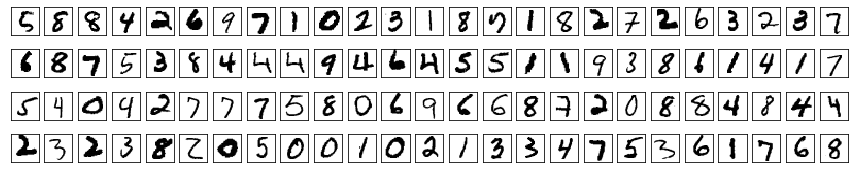

In [101]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_imgs = np.array([x.ravel() for x in train_images])
test_imgs = np.array([y.ravel() for y in test_images])

img_SIZE = train_images.shape[1]*train_images.shape[2]

orig_A1, lim_A1 = 2000, 2000
dataset = "mnist"
mnist_result = entropy_learning(orig_A1, lim_A1, dataset)

print(f"entropy labelled learning: {mnist_result}[%]")

### Renyi entropyについて

In [29]:
import dit
from dit.other import renyi_entropy

In [115]:
d = np.array([0.1, 0.2, 0.3, 0.4])

# renyi entropy
d = np.array([0.1, 0.2, 0.3, 0.4])
dist = dit.Distribution(['0', '1', '2', '3'], d)
for r in range(10, 0, -1):
    Hr = renyi_entropy(dist, r)
    sum_rth = np.sum(np.power(d, r))
    Hr_2 = np.log2(sum_rth)/(1 - r)
    print(f"{r}-th renyi entropy: {Hr}")
    print(f"\thandmade renyi entropy: {Hr_2}")
    
# entropy
info_con = (-1)*np.log2(d)
Hp = np.sum(np.multiply(d, info_con))
print(f"shannon entropy: {Hp}")

10-th renyi entropy: 1.4598787111053293
	handmade renyi entropy: 1.4598787111053295
9-th renyi entropy: 1.4737848556395896
	handmade renyi entropy: 1.4737848556395896
8-th renyi entropy: 1.490377086143525
	handmade renyi entropy: 1.490377086143525
7-th renyi entropy: 1.510457669091529
	handmade renyi entropy: 1.5104576690915292
6-th renyi entropy: 1.5351899638969158
	handmade renyi entropy: 1.5351899638969155
5-th renyi entropy: 1.5663361416302486
	handmade renyi entropy: 1.5663361416302486
4-th renyi entropy: 1.6067022764888172
	handmade renyi entropy: 1.6067022764888172
3-th renyi entropy: 1.660964047443681
	handmade renyi entropy: 1.660964047443681
2-th renyi entropy: 1.7369655941662059
	handmade renyi entropy: 1.7369655941662059
1-th renyi entropy: 1.8464393446710154
	handmade renyi entropy: nan
shannon entropy: 1.8464393446710154


In [130]:
# renyi entropy labelling
def renyi_label(r, probas):
    info_con = (-1)*np.log2(probas)
    
    sum_rth = np.sum(np.power(probas, r))
    Hr_2 = np.log2(sum_rth)/(1 - r)

    labels = np.array([i for i, Ipk in enumerate(info_con) if Ipk <= Hr_2])
    if len(labels) == 0:
        # other entropies
        dist = dit.Distribution(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], probas)
        Hr = renyi_entropy(dist, r)
        Hp = np.sum(np.multiply(probas, info_con))
        print(f"\thandmade renyi entropy: {Hr_2}")
        print(f"renyi entropy: {Hr}")
        print(f"\tshannon entropy: {Hp}")
    
    return labels

In [103]:
def renyi_learning(r, orig_A, lim_A, dataset):
    
    model = LR().fit(train_imgs[orig_A:orig_A + lim_A], train_labels[orig_A:orig_A + lim_A])
    acc = accuracy_score(test_labels, model.predict(test_imgs))
    print(f"learnt with original labels: {acc*100}[%]")

    # generate an annotator
    a1_model = LR().fit(train_imgs[:orig_A], train_labels[:orig_A])
    a1_proba = a1_model.predict_proba(train_imgs[orig_A:orig_A + lim_A])

    # entropy labelling
    mul_labels = [renyi_label(r, probas) for probas in a1_proba]
    m_labels = []

    for labels in mul_labels:
         [m_labels.append(l) for l in labels]
    
    # images duplication
    dupld_imgs = np.array([dup_imgs(img, mul_labels[i]) for i, img in enumerate(train_imgs[orig_A:orig_A + lim_A])])

    d_imgs = []

    for img in dupld_imgs:
        a = img.shape
        n = a[0]
        if (n == img_SIZE):
            d_imgs.append(img)
        else:
            for _ in range(n):
                d_imgs.append(img[0])

    d_imgs = np.array(d_imgs)
    
    # 画像の複製確認 不要ならコメントアウト
    plt.figure(figsize = (15, 3))
    for i in range(len(d_imgs[:100])):
        plt.subplot(4, 25 , i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid('off')
        if (dataset == "mnist"):
            plt.imshow(d_imgs[i].reshape(28, 28), cmap = plt.cm.binary)
        elif (dataset == "cifar10" or dataset == "cifar100"):
            plt.imshow(d_imgs[i].reshape(32, 32, 3), cmap = plt.cm.binary)

    # final learning
    final_model = LR().fit(d_imgs, m_labels)
    acc = accuracy_score(test_labels, final_model.predict(test_imgs))
    return acc*100

これをみる限り，Renyiの方がshannonよりも小さい値になるらしい... つまりthrshldとしてより厳しい  
にもかかわらずrを大きくするとラベルがつかなくないデータがなくなり，そこそこの精度が出る...??  
あとr = 1に設定してもshannon entropyすら再現できない

learnt with original labels: 84.48[%]
renyi entropy labelled learning: 81.58999999999999[%]


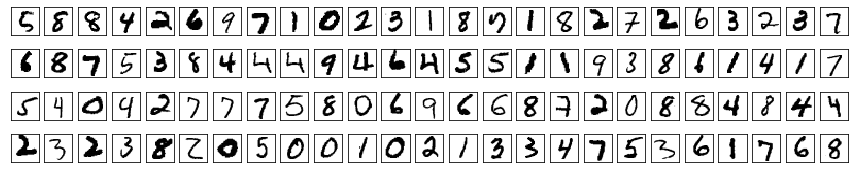

In [132]:
orig_A1, lim_A1 = 2000, 2000
dataset = "mnist"
r = 2
mnist_result = renyi_learning(r, orig_A1, lim_A1, dataset)
print(f"renyi entropy labelled learning: {mnist_result}[%]")

#### エントロピー計算がアンダーフローしてラベルがつかないデータがある

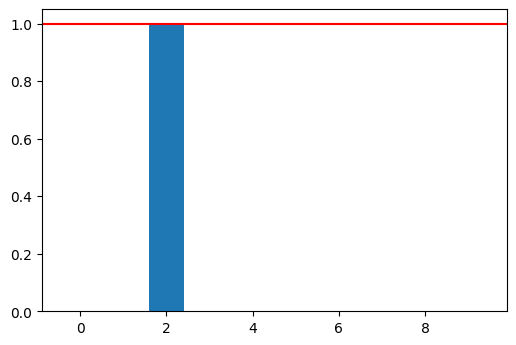

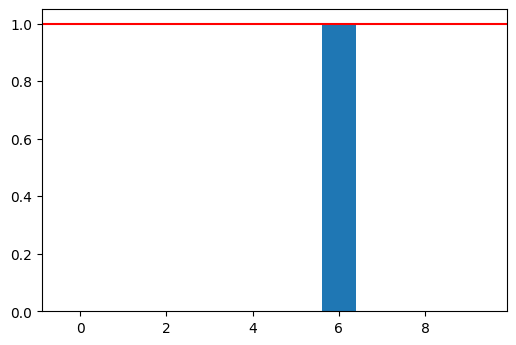

In [96]:
a = [6.71701998e-10, 1.01835172e-52, 9.99999997e-01, 5.78264510e-22,
 5.27712768e-25, 2.14917477e-41, 3.73904635e-19, 2.89278740e-41,
 1.85833139e-38, 2.25436866e-09]

b = [1.11734186e-22, 1.76022095e-37, 1.50397791e-17, 4.14017075e-41,
 5.80448145e-14, 2.82678628e-20, 1.00000000e+00, 6.39461495e-49,
 4.16499589e-37, 5.03002740e-27]

thrshld_a = np.power(2, (-1)*float(8.944507229349886e-08))
thrshld_b = np.power(2, (-1)*float(2.6368323312733595e-12))

plt.figure(dpi = 100)
plt.axhline(y = thrshld_a, color='r', linestyle='-')
plt.bar([i for i in range(10)], [float(n) for n in a])
plt.figure(dpi = 100)
plt.bar([i for i in range(10)], [float(n) for n in b])
plt.axhline(y = thrshld_b, color='r', linestyle='-')